In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import imageio
import copy
from tensorboardX import SummaryWriter
import pickle 

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)
#train_dataset.train_labels = train_dataset.train_labels.float()
#test_dataset.test_labels = test_dataset.test_labels.float()

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

#arguments
#model_name = 'LeNet_300_100'
training_epochs=100
#retraining_epochs=50
#temp_list = [1, 5, 10, 15, 20, 25, 30]

In [3]:
#4D tensor fix for conv-net
test_data_full = test_data_full.view(10000, 1, 28, 28)
train_data_full = train_data_full.view(60000, 1, 28, 28)
model_name = 'SWSModel'

### 1. Train Model

**Default Training**

Epoch: 10. Training Accuracy: 99.20. Test Accuracy: 98.53
Epoch: 20. Training Accuracy: 99.61. Test Accuracy: 98.9
Epoch: 30. Training Accuracy: 99.56. Test Accuracy: 98.81
Epoch: 40. Training Accuracy: 99.71. Test Accuracy: 98.93
Epoch: 50. Training Accuracy: 99.73. Test Accuracy: 98.98
Epoch: 60. Training Accuracy: 99.80. Test Accuracy: 98.94
Epoch: 70. Training Accuracy: 99.78. Test Accuracy: 98.94
Epoch: 80. Training Accuracy: 99.72. Test Accuracy: 98.78
Epoch: 90. Training Accuracy: 99.77. Test Accuracy: 98.79
Epoch: 100. Training Accuracy: 99.74. Test Accuracy: 98.7


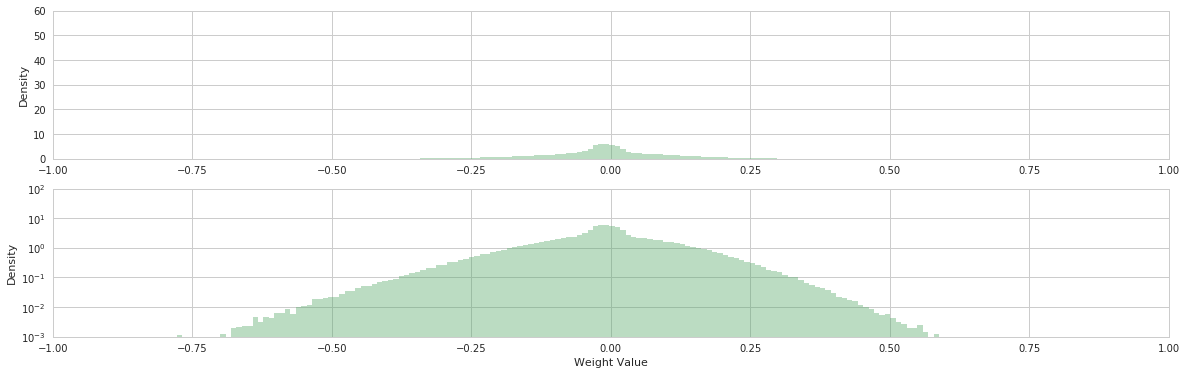

In [55]:
model = models.SWSModel().cuda()
#print_dims(model)
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)
graph_title='sws_original_model/'

for epoch in range(training_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)
    
    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
    
show_sws_weights(model)
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))

### 2. Re-train Model with GMM Constraints

In [56]:
temp = 8
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
kd_outputs = model.kd_targets(train_data_full,T=temp)
kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

In [57]:
%%notify

alpha, beta = (25000, 10)
model_retrain = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
gmp = GaussianMixturePrior(16, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta))

test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
acc_history = np.array([train_acc[0], test_acc[0]])
stddev_history = np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy())
mean_history = gmp.means.data.clone().cpu().numpy()
mixprop_history = gmp.rhos.exp().data.clone().cpu().numpy()

sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]
#ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.MSELoss()
learning_rate_kd = 1e-4
optimizer_kd_1 = torch.optim.Adam(model_retrain.conv1.parameters(), lr=learning_rate_kd)
optimizer_kd_2 = torch.optim.Adam(model_retrain.conv2.parameters(), lr=learning_rate_kd)
optimizer_kd_3 = torch.optim.Adam(model_retrain.fc1.parameters(), lr=learning_rate_kd)
optimizer_kd_4 = torch.optim.Adam(model_retrain.fc2.parameters(), lr=learning_rate_kd)
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_retrain.parameters(), lr=1e-4)
optimizer_gmp1 = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='retrain_model/'

retraining_epochs = 40
#decay = np.linspace(5e-7, 5e-6, retraining_epochs)
#decay = 5e-7 * np.power(10, decay)
#decay = 5e-5 * (1 - 1 / np.power(10, decay))

exp_name = "kd_m{}_a{}_b{}_r{}".format(model_retrain.name, alpha, beta, retraining_epochs)

for epoch in range(retraining_epochs):
    ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch+1)))
    #tau = float(decay[epoch])
    tau=5e-7
    #model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer, optimizer_gmp1, optimizer_gmp2, criterion, train_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_1, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_2, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_3, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_4, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)

    test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
    train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
    weight_penalty = get_weight_penalty(model_retrain)

    stddev_history = np.vstack((stddev_history,  np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy()) ))
    mean_history = np.vstack((mean_history, gmp.means.data.clone().cpu().numpy() ))
    mixprop_history = np.vstack((mixprop_history, gmp.rhos.exp().data.clone().cpu().numpy() ))
    acc_history = np.vstack(( acc_history, np.array([train_acc[0], test_acc[0]]) ))

    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model_retrain.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        gmp.print_batch = True
        print ('Tau:{}'.format(tau))
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
    show_sws_weights(model = model_retrain, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch, accuracy = test_acc[0], savefile = exp_name)
    joint_plot(model_retrain, model, gmp, epoch, retraining_epochs, test_acc[0], savefile = exp_name)
        #show_all_weights(model_retrain)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0


**Epoch: 1**

Layer Loss: 625.112
Layer Loss: 15.462
Layer Loss: 8441.525
Layer Loss: 25.001
Layer Loss: 365487.906
Layer Loss: 248.797
Layer Loss: 3303.051
Layer Loss: 5.472
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -1037279.125


**Epoch: 2**

**Epoch: 3**

**Epoch: 4**

**Epoch: 5**

**Epoch: 6**

**Epoch: 7**

**Epoch: 8**

**Epoch: 9**

**Epoch: 10**

Tau:5e-07
Epoch: 10. Training Accuracy: 99.49. Test Accuracy: 98.57
Means: [-0.571, -0.561, -0.258, -0.361, -0.289, -0.062, -0.168, -0.104, 0.05, 0.266, 0.159, 0.267, 0.359, 0.513, 0.062]
Mixing Proportions: [-5.661, -15.959, -4.101, -8.324, -15.643, -2.71, -9.175, -11.433, -14.781, -15.394, -4.44, -12.923, -6.412, -9.196, -3.08]
Precisions: [11.922, 7.839, 7.824, 7.927, 7.826, 7.824, 8.184, 7.824, 7.824, 7.824, 7.824, 7.878, 7.824, 7.833, 7.825, 8.074]


**Epoch: 11**

Layer Loss: 5447.815
Layer Loss: 195.781
Layer Loss: 28996.734
Layer Loss: 72.365
Layer Loss: -1992100.125
Layer Loss: -2056.303
Layer Loss: 8471.716
Layer Loss: -24.744
0-neglogprop Loss: 241492.047
Remaining-neglogprop Loss: -2556040.500


**Epoch: 12**

**Epoch: 13**

**Epoch: 14**

**Epoch: 15**

**Epoch: 16**

**Epoch: 17**

**Epoch: 18**

**Epoch: 19**

**Epoch: 20**

Tau:5e-07
Epoch: 20. Training Accuracy: 99.54. Test Accuracy: 98.61
Means: [-0.577, -0.561, -0.258, -0.368, -0.289, -0.063, -0.168, -0.104, 0.051, 0.266, 0.17, 0.268, 0.363, 0.522, 0.071]
Mixing Proportions: [-5.289, -19.893, -3.731, -7.979, -19.305, -2.341, -13.7, -15.88, -18.782, -19.175, -4.072, -17.532, -6.036, -8.818, -2.711]
Precisions: [11.922, 7.847, 7.824, 7.931, 7.826, 7.824, 8.197, 7.824, 7.824, 7.824, 7.824, 7.898, 7.824, 7.834, 7.825, 8.093]


**Epoch: 21**

Layer Loss: 4887.270
Layer Loss: 181.517
Layer Loss: 28616.396
Layer Loss: 68.137
Layer Loss: -1992995.750
Layer Loss: -2056.238
Layer Loss: 7932.493
Layer Loss: -24.823
0-neglogprop Loss: 241459.297
Remaining-neglogprop Loss: -2555700.000


**Epoch: 22**

**Epoch: 23**

**Epoch: 24**

**Epoch: 25**

**Epoch: 26**

**Epoch: 27**

**Epoch: 28**

**Epoch: 29**

**Epoch: 30**

Tau:5e-07
Epoch: 30. Training Accuracy: 99.53. Test Accuracy: 98.6
Means: [-0.577, -0.561, -0.258, -0.376, -0.289, -0.065, -0.168, -0.104, 0.051, 0.266, 0.176, 0.268, 0.363, 0.525, 0.076]
Mixing Proportions: [-5.081, -20.376, -3.523, -7.771, -20.375, -2.134, -17.8, -19.205, -20.285, -20.374, -3.865, -19.869, -5.829, -8.61, -2.503]
Precisions: [11.922, 7.847, 7.824, 7.931, 7.826, 7.824, 8.197, 7.824, 7.824, 7.824, 7.824, 7.899, 7.824, 7.835, 7.825, 8.094]


**Epoch: 31**

Layer Loss: 4841.271
Layer Loss: 175.586
Layer Loss: 28608.914
Layer Loss: 67.713
Layer Loss: -1992929.375
Layer Loss: -2056.150
Layer Loss: 7914.217
Layer Loss: -24.835
0-neglogprop Loss: 241414.422
Remaining-neglogprop Loss: -2555695.250


**Epoch: 32**

**Epoch: 33**

**Epoch: 34**

**Epoch: 35**

**Epoch: 36**

**Epoch: 37**

**Epoch: 38**

**Epoch: 39**

**Epoch: 40**

Tau:5e-07
Epoch: 40. Training Accuracy: 99.56. Test Accuracy: 98.6
Means: [-0.575, -0.561, -0.259, -0.381, -0.289, -0.068, -0.168, -0.104, 0.051, 0.266, 0.178, 0.268, 0.361, 0.526, 0.079]
Mixing Proportions: [-5.07, -20.306, -3.512, -7.76, -20.305, -2.122, -19.954, -20.305, -20.305, -20.307, -3.854, -20.306, -5.817, -8.599, -2.492]
Precisions: [11.922, 7.847, 7.824, 7.931, 7.826, 7.824, 8.198, 7.824, 7.824, 7.824, 7.824, 7.899, 7.824, 7.834, 7.825, 8.094]


<IPython.core.display.Javascript object>

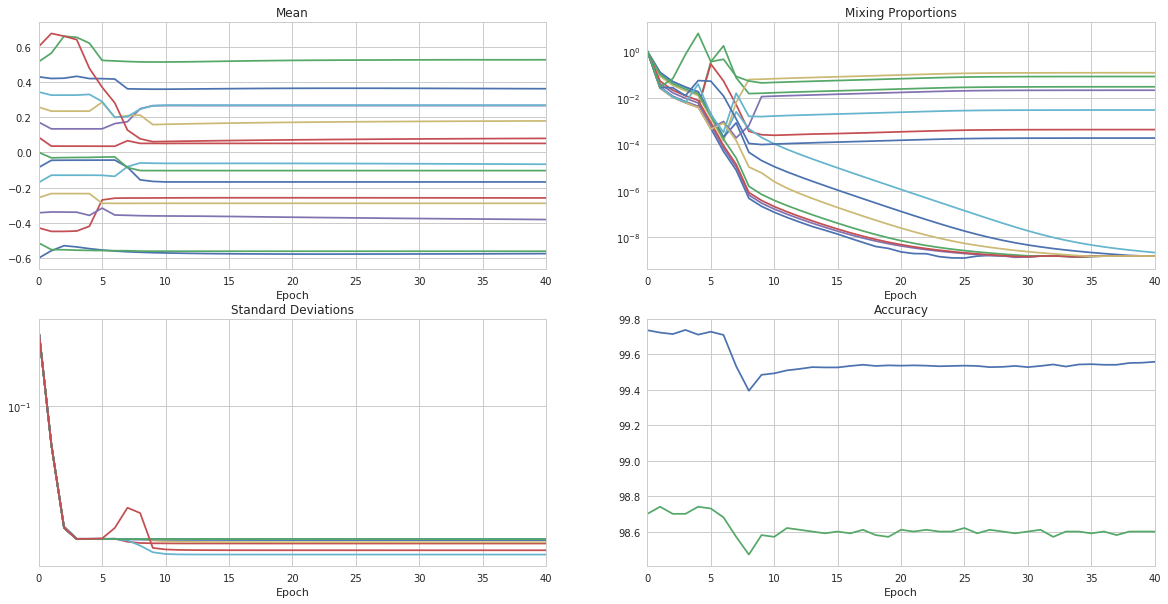

In [58]:
torch.save(model_retrain, model_dir + 'mnist_retrain_{}.m'.format(exp_name))
with open(model_dir + 'mnist_retrain_{}.m'.format(exp_name),'wb') as f:
    pickle.dump(gmp, f)
draw_sws_graphs(mean_history, stddev_history, mixprop_history, acc_history, exp_name)
images = []
filenames = ["figs/{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/{}.gif'.format(exp_name), images)
ipd.HTML('<img src="./exp/{}.gif">'.format(exp_name))

In [59]:
images = []
filenames = ["figs/jp_{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/jp_{}.gif'.format(exp_name), images)
ipd.HTML('<img src="./exp/jp_{}.gif">'.format(exp_name))

### 3. Prune Model

In [19]:
orig_acc = (test_accuracy(test_data_full, test_labels_full, model))

In [20]:
retrain_acc = (test_accuracy(test_data_full, test_labels_full, model_retrain))

(98.37, 1.4821618795394897)


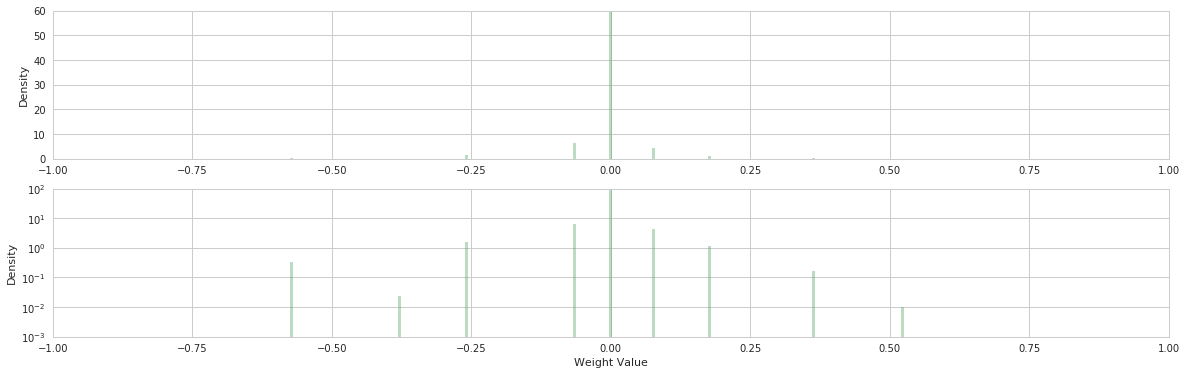

In [79]:
model_prune = copy.deepcopy(model_retrain)
model_prune.load_state_dict(sws_prune(model_prune, gmp))
prune_acc = (test_accuracy(test_data_full, test_labels_full, model_prune))
print (prune_acc)
show_sws_weights(model_prune)

In [80]:
(special_flatten(model_prune.state_dict())==0).sum()/642460.0

0.9221445693117081

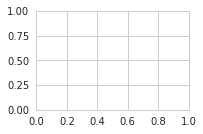

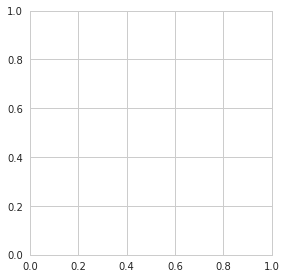

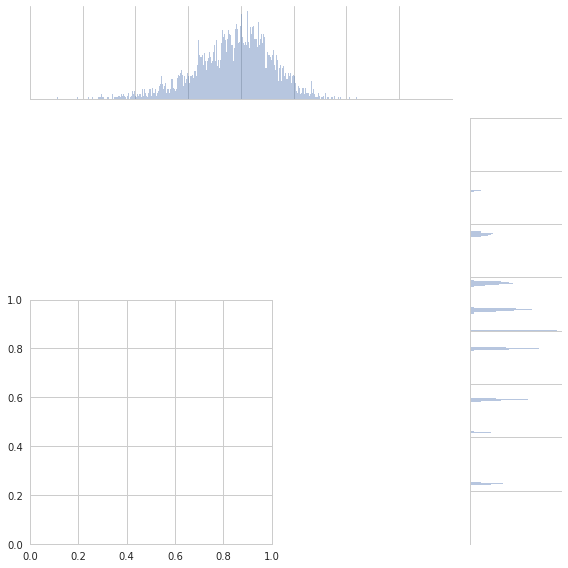

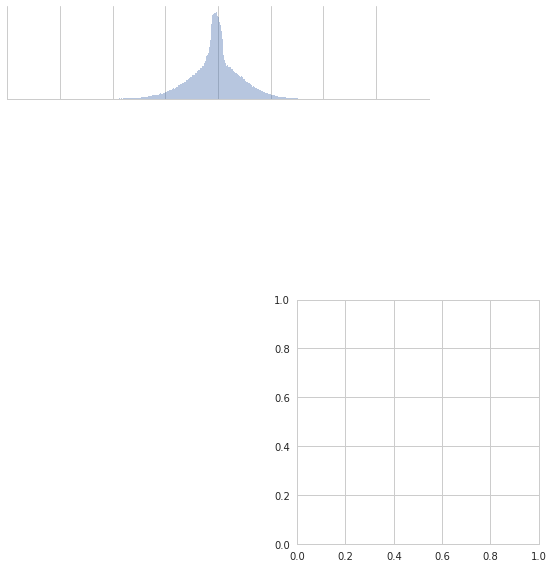

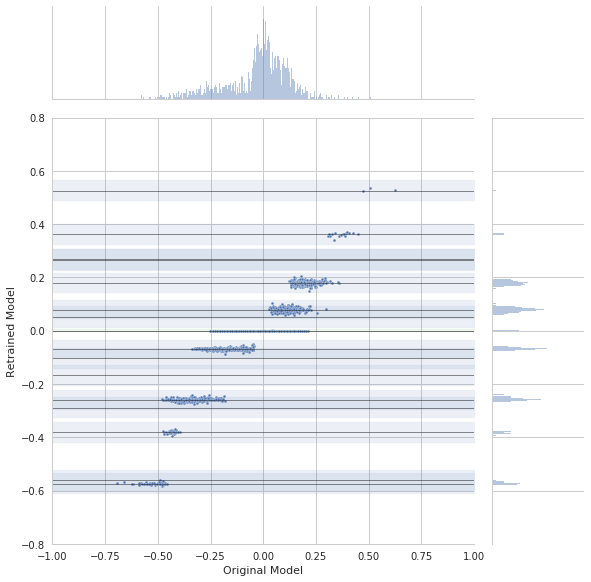

In [74]:

    
def jp2(model, model_orig, gmp, savefile = ""):
    """
    joint distribution plot weights before and after sws retraining
    """
    #plt.figure(figsize=(30,30))
    plt.subplot(2,2,1)
    layer = "conv1.weight"
    weights_T = model.state_dict()[layer].view(-1).cpu().numpy()

    weights_0 = model_orig.state_dict()[layer].view(-1).cpu().numpy()

    #get mean, stddev
    mu_T = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])
    std_T = np.sqrt(1/np.exp(gmp.gammas.clone().data.cpu().numpy()))

    x0 = -1.2
    x1 = 1.2
    I = np.random.permutation(len(weights_0))
    f = sns.jointplot(weights_0[I], weights_T[I], size=8, kind="scatter", color="b", stat_func=None, edgecolor='w',
                      marker='o', joint_kws={"s": 8}, marginal_kws=dict(bins=1000), ratio=4)
    f.ax_joint.hlines(mu_T, x0, x1, lw=0.5)

    for k in range(len(mu_T)):
        if k == 0:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='g', alpha=0.1)
        else:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='b', alpha=0.1)
    
    #plt.title("Epoch: %d /%d\nTest accuracy: %.4f " % (epoch+1, retraining_epochs, acc))
    f.ax_marg_y.set_xscale("log")
    f.set_axis_labels("Original Model", "Retrained Model")
    f.ax_marg_x.set_xlim(-1, 1)
    f.ax_marg_y.set_ylim(-0.8, 0.8)
    
    plt.subplot(2,2,2)
    layer = "conv2.weight"
    weights_T = model.state_dict()[layer].view(-1).cpu().numpy()

    weights_0 = model_orig.state_dict()[layer].view(-1).cpu().numpy()

    #get mean, stddev
    mu_T = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])
    std_T = np.sqrt(1/np.exp(gmp.gammas.clone().data.cpu().numpy()))

    x0 = -1.2
    x1 = 1.2
    I = np.random.permutation(len(weights_0))
    f = sns.jointplot(weights_0[I], weights_T[I], size=8, kind="scatter", color="b", stat_func=None, edgecolor='w',
                      marker='o', joint_kws={"s": 8}, marginal_kws=dict(bins=1000), ratio=4)
    f.ax_joint.hlines(mu_T, x0, x1, lw=0.5)

    for k in range(len(mu_T)):
        if k == 0:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='g', alpha=0.1)
        else:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='b', alpha=0.1)
    
    #plt.title("Epoch: %d /%d\nTest accuracy: %.4f " % (epoch+1, retraining_epochs, acc))
    f.ax_marg_y.set_xscale("log")
    f.set_axis_labels("Original Model", "Retrained Model")
    f.ax_marg_x.set_xlim(-1, 1)
    f.ax_marg_y.set_ylim(-0.8, 0.8)
    
    plt.subplot(2,2,3)
    layer = "fc1.weight"
    weights_T = model.state_dict()[layer].view(-1).cpu().numpy()

    weights_0 = model_orig.state_dict()[layer].view(-1).cpu().numpy()

    #get mean, stddev
    mu_T = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])
    std_T = np.sqrt(1/np.exp(gmp.gammas.clone().data.cpu().numpy()))

    x0 = -1.2
    x1 = 1.2
    I = np.random.permutation(len(weights_0))
    f = sns.jointplot(weights_0[I], weights_T[I], size=8, kind="scatter", color="b", stat_func=None, edgecolor='w',
                      marker='o', joint_kws={"s": 8}, marginal_kws=dict(bins=1000), ratio=4)
    f.ax_joint.hlines(mu_T, x0, x1, lw=0.5)

    for k in range(len(mu_T)):
        if k == 0:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='g', alpha=0.1)
        else:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='b', alpha=0.1)
    
    #plt.title("Epoch: %d /%d\nTest accuracy: %.4f " % (epoch+1, retraining_epochs, acc))
    f.ax_marg_y.set_xscale("log")
    f.set_axis_labels("Original Model", "Retrained Model")
    f.ax_marg_x.set_xlim(-1, 1)
    f.ax_marg_y.set_ylim(-0.8, 0.8)
    
    plt.subplot(2,2,4)
    layer = "fc2.weight"
    weights_T = model.state_dict()[layer].view(-1).cpu().numpy()

    weights_0 = model_orig.state_dict()[layer].view(-1).cpu().numpy()

    #get mean, stddev
    mu_T = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])
    std_T = np.sqrt(1/np.exp(gmp.gammas.clone().data.cpu().numpy()))

    x0 = -1.2
    x1 = 1.2
    I = np.random.permutation(len(weights_0))
    f = sns.jointplot(weights_0[I], weights_T[I], size=8, kind="scatter", color="b", stat_func=None, edgecolor='w',
                      marker='o', joint_kws={"s": 8}, marginal_kws=dict(bins=1000), ratio=4)
    f.ax_joint.hlines(mu_T, x0, x1, lw=0.5)

    for k in range(len(mu_T)):
        if k == 0:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='g', alpha=0.1)
        else:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='b', alpha=0.1)
    
    #plt.title("Epoch: %d /%d\nTest accuracy: %.4f " % (epoch+1, retraining_epochs, acc))
    f.ax_marg_y.set_xscale("log")
    f.set_axis_labels("Original Model", "Retrained Model")
    f.ax_marg_x.set_xlim(-1, 1)
    f.ax_marg_y.set_ylim(-0.8, 0.8)
    
    plt.show()
    
    
    
    
    #plt.savefig("./jp.png", bbox_inches='tight', dpi=1000)
    #plt.show()
jp2(model_retrain, model, gmp)

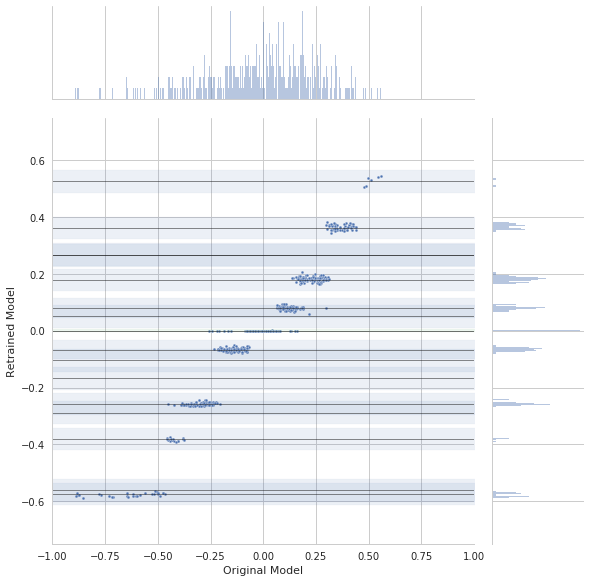

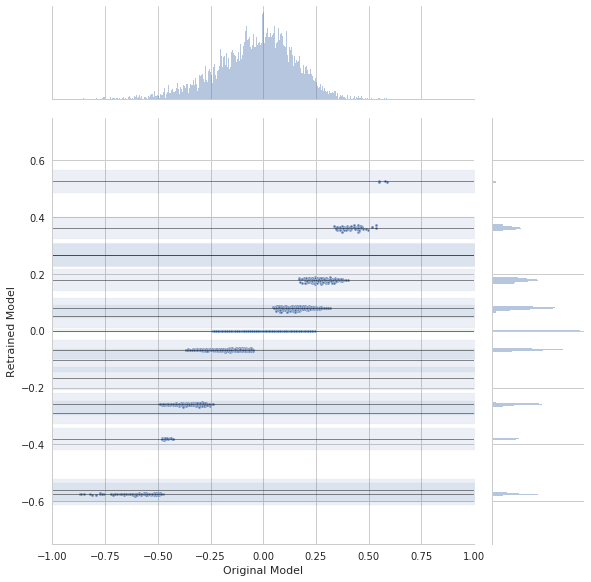

In [ ]:
def jp3(T, T0, gmp, savefile = ""):
    """
    joint distribution plot weights before and after sws retraining
    """
    #plt.figure(figsize=(30,30))
    weights_T = T.view(-1).cpu().numpy()

    weights_0 = T0.view(-1).cpu().numpy()

    #get mean, stddev
    mu_T = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])
    std_T = np.sqrt(1/np.exp(gmp.gammas.clone().data.cpu().numpy()))

    x0 = -1.2
    x1 = 1.2
    I = np.random.permutation(len(weights_0))
    f = sns.jointplot(weights_0[I], weights_T[I], size=8, kind="scatter", color="b", stat_func=None, edgecolor='w',
                      marker='o', joint_kws={"s": 8}, marginal_kws=dict(bins=600), ratio=4)
    f.ax_joint.hlines(mu_T, x0, x1, lw=0.5)

    for k in range(len(mu_T)):
        if k == 0:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='g', alpha=0.1)
        else:
            f.ax_joint.fill_between(np.linspace(x0, x1, 10), mu_T[k] - 2 * std_T[k], mu_T[k] + 2 * std_T[k],
                                    color='b', alpha=0.1)
    
    #plt.title("Epoch: %d /%d\nTest accuracy: %.4f " % (epoch+1, retraining_epochs, acc))
    f.ax_marg_y.set_xscale("log")
    f.set_axis_labels("Original Model", "Retrained Model")
    f.ax_marg_x.set_xlim(-1, 1)
    f.ax_marg_y.set_ylim(-0.75, 0.75)
    plt.savefig("./jp_{}.png".format(savefile), bbox_inches='tight', dpi=500)
    plt.show()
jp3(model_retrain.state_dict()["conv1.weight"], model.state_dict()["conv1.weight"], gmp, "conv1")
jp3(model_retrain.state_dict()["conv2.weight"], model.state_dict()["conv2.weight"], gmp, "conv2")
jp3(model_retrain.state_dict()["fc1.weight"], model.state_dict()["fc1.weight"], gmp, "fc1")
jp3(model_retrain.state_dict()["fc2.weight"], model.state_dict()["fc2.weight"], gmp, "fc2")

In [47]:
model_orig = model

In [48]:
weights_orig = np.array([], dtype=np.float32)
for layer in model_orig.state_dict():
    weights_orig = np.hstack( (weights_orig, model.state_dict()[layer].view(-1).cpu().numpy()) )
        
weights_retrain = np.array([], dtype=np.float32)
for layer in model_retrain.state_dict():
    weights_retrain = np.hstack( (weights_retrain, model_retrain.state_dict()[layer].view(-1).cpu().numpy()) )
        
weights_prune = np.array([], dtype=np.float32)
for layer in model_prune.state_dict():
    weights_prune = np.hstack( (weights_prune, model_prune.state_dict()[layer].view(-1).cpu().numpy()) )

In [49]:
ylims = [1e-3, 1e2]
xlims = [-0.75, 0.75]

In [50]:
print(orig_acc[0], retrain_acc[0], prune_acc[0]) #92.4% pruned

NameError: name 'orig_acc' is not defined

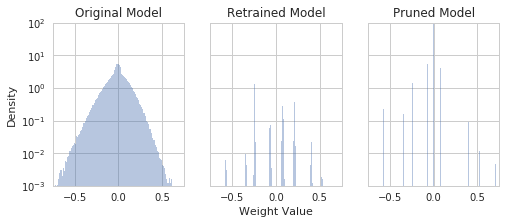

In [51]:
plt.clf()
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
sns.distplot(weights_orig, kde=False, color="b",bins=200,norm_hist=True, hist_kws={'log':True})
#plot mean and precision
plt.xlim(xlims)
plt.ylim(ylims)
plt.title("Original Model")
plt.ylabel("Density")
#plt.show()

#plt.clf()
plt.subplot(1,3,2)
sns.distplot(weights_retrain, kde=False, color="b",bins=200,norm_hist=True, hist_kws={'log':True})
#plot mean and precision
#plt.ylabel("Density")
plt.xlabel("Weight Value")
plt.xlim(xlims)
plt.ylim(ylims)
plt.gca().set_yticklabels([])
plt.title("Retrained Model")
#plt.show()

#plt.clf()
plt.subplot(1,3,3)
sns.distplot(weights_prune, kde=False, color="b",bins=200,norm_hist=True, hist_kws={'log':True})
#plot mean and precision
plt.xlim(xlims)
plt.ylim(ylims)
plt.gca().set_yticklabels([])
plt.title("Pruned Model")
plt.savefig("./model_layers.eps", bbox_inches='tight')
#plt.ylabel("Density")
#plt.show()

**Default Training**

Epoch: 10. Training Accuracy: 97.85. Test Accuracy: 97.66


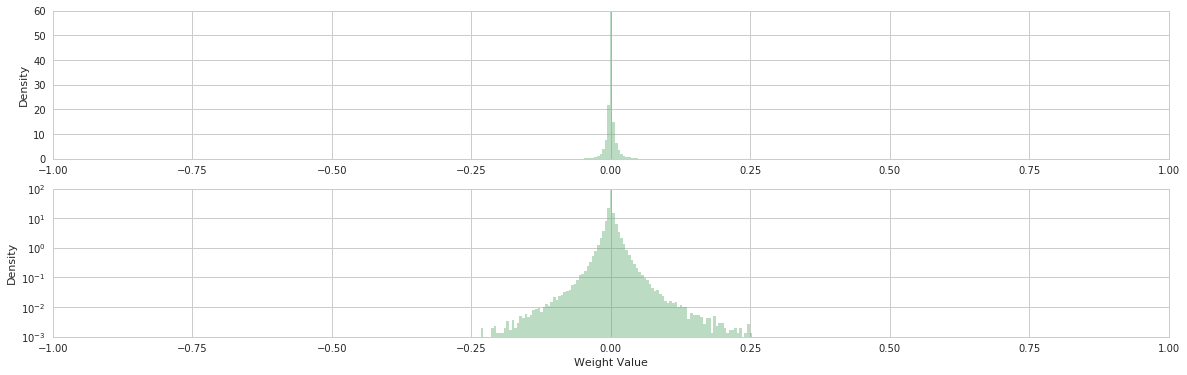

Epoch: 20. Training Accuracy: 98.31. Test Accuracy: 98.08


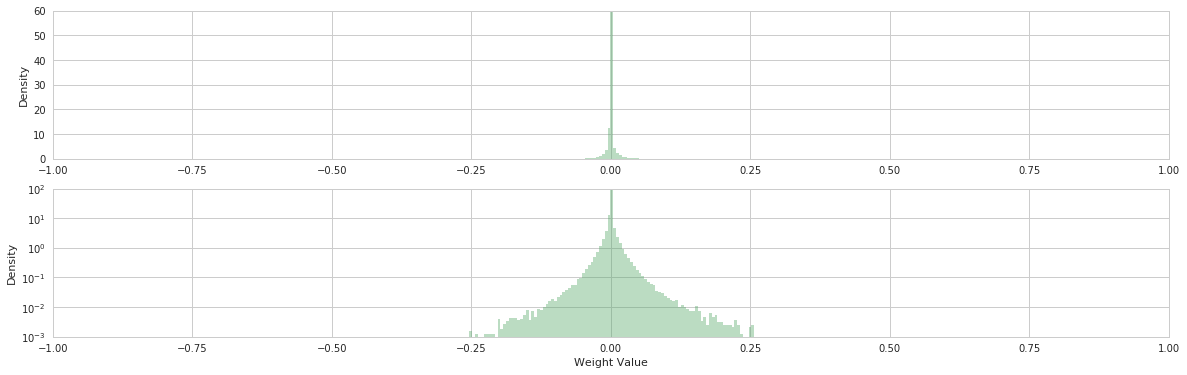

Epoch: 30. Training Accuracy: 98.59. Test Accuracy: 98.27


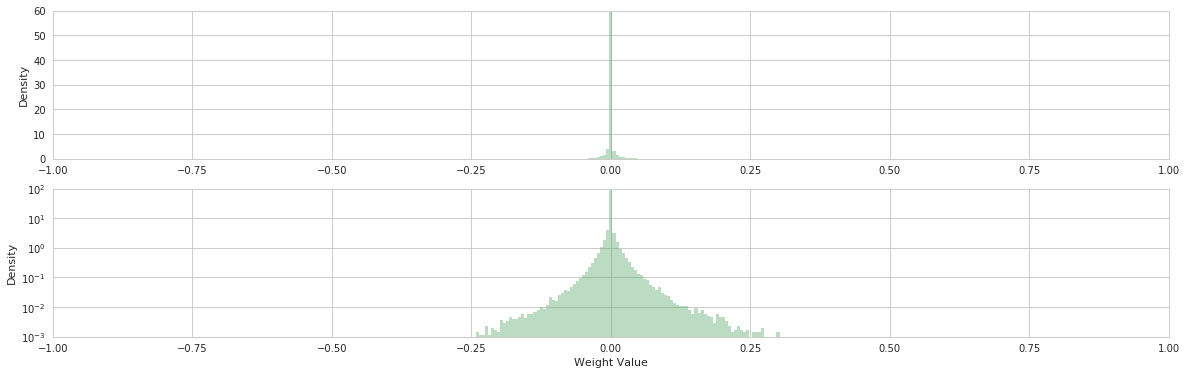

Epoch: 40. Training Accuracy: 98.68. Test Accuracy: 98.16


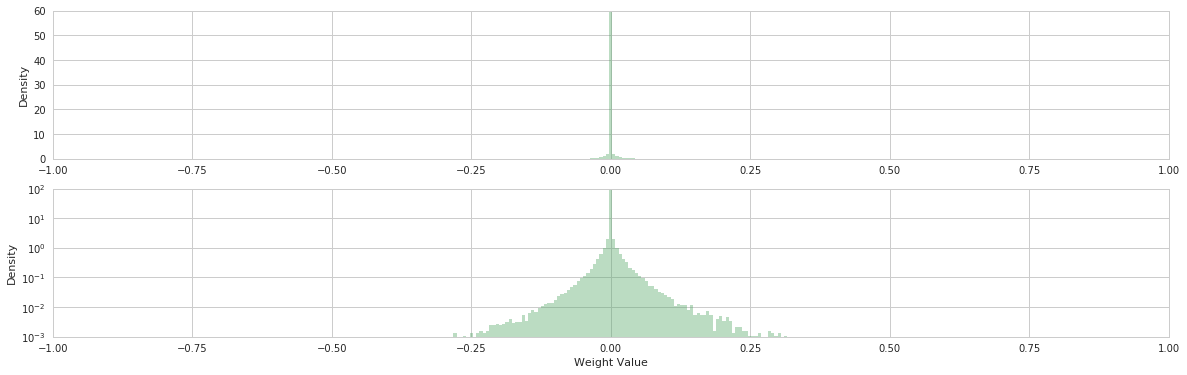

Epoch: 50. Training Accuracy: 98.68. Test Accuracy: 98.16


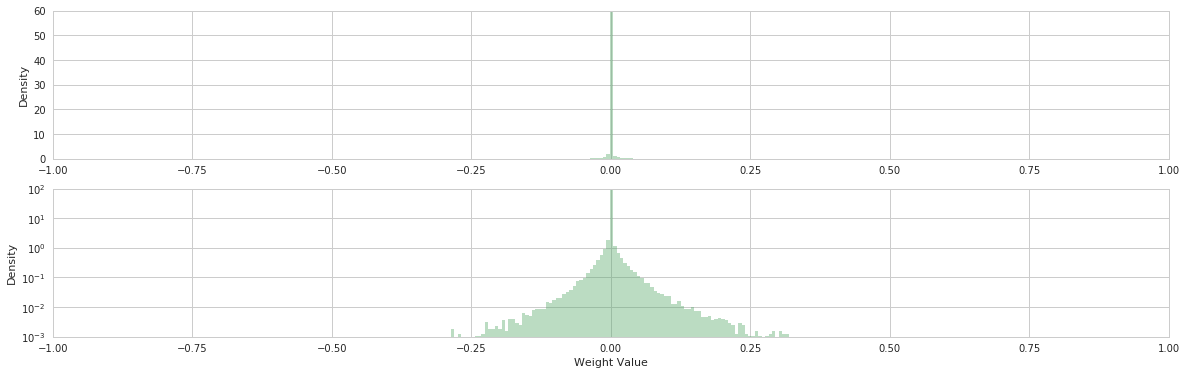

Epoch: 60. Training Accuracy: 98.78. Test Accuracy: 98.4


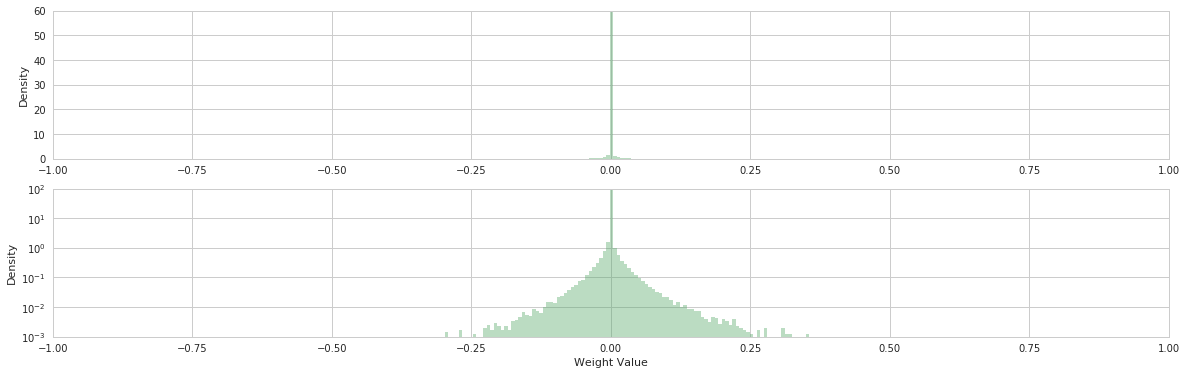

Epoch: 70. Training Accuracy: 98.84. Test Accuracy: 98.2


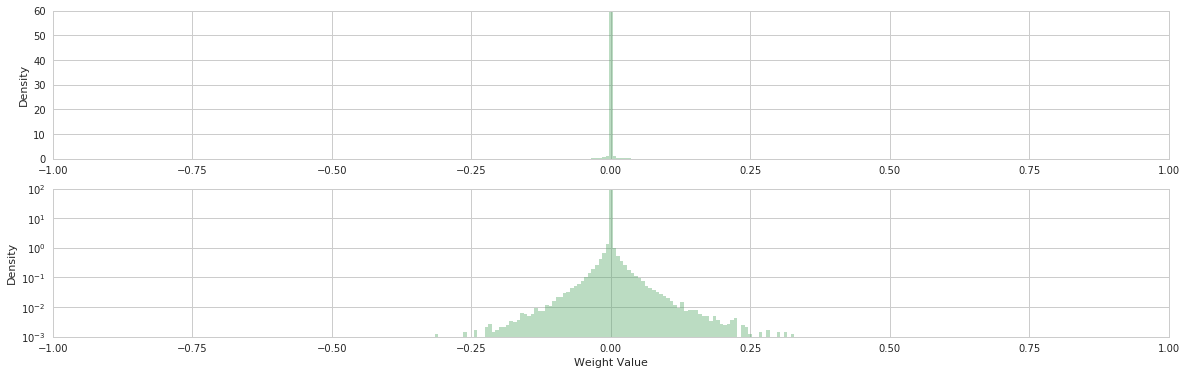

Epoch: 80. Training Accuracy: 98.65. Test Accuracy: 98.09


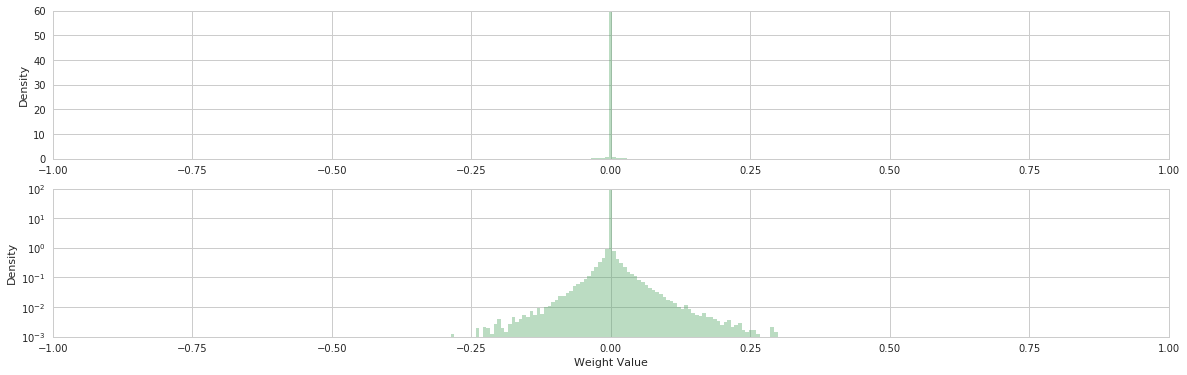

Epoch: 90. Training Accuracy: 98.86. Test Accuracy: 98.33


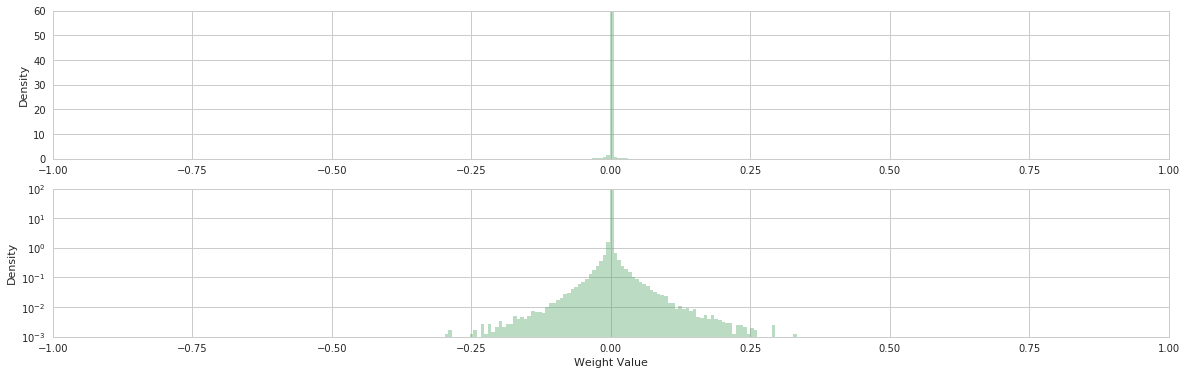

Epoch: 100. Training Accuracy: 98.70. Test Accuracy: 98.16


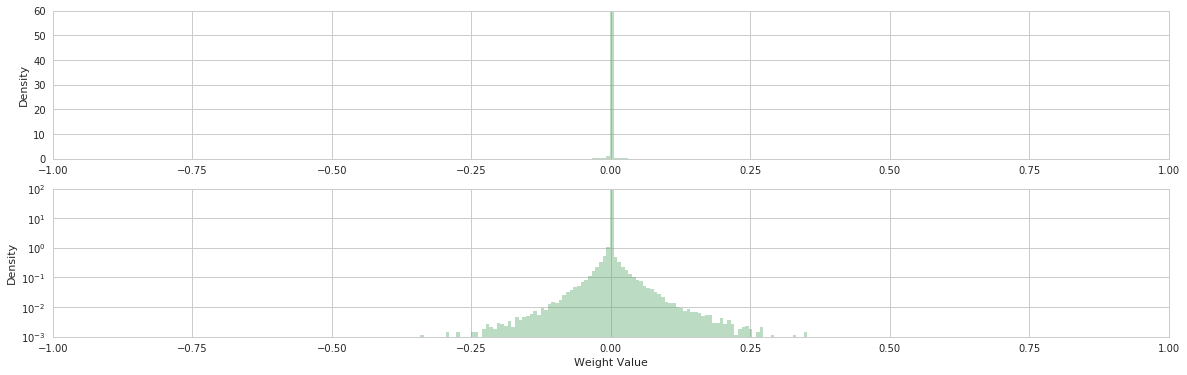

In [17]:
model_wd = models.SWSModel().cuda()
#print_dims(model)
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model_wd.parameters(), lr=learning_rate, weight_decay = 0.001)
graph_title='sws_original_model/'

for epoch in range(training_epochs):
    model_wd, loss = train_epoch(model_wd, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model_wd)
    train_acc = test_accuracy(train_data_full, train_labels_full, model_wd)
    weight_penalty = get_weight_penalty(model_wd)
    
    if (trueAfterN(epoch, 10)):
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
        show_sws_weights(model_wd)
torch.save(model_wd, model_dir + 'mnist_wd_{}_{}.m'.format(model_wd.name, training_epochs))

In [11]:
from model_utils import model_prune as mp

In [14]:
model_c = copy.deepcopy(model_wd)
pruner = mp(model_wd.state_dict())
percentile_list = range(0,101,1)


dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
for i,lim in enumerate(percentile_list):
    model_c.load_state_dict(pruner.deviation_prune(lim))
    test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
    train_acc = test_accuracy(train_data_full, train_labels_full, model_c)

    dev_res['train acc'].append(train_acc[0])
    dev_res['test acc'].append(test_acc[0])
    dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)

In [21]:
print_dims(model)

25x1x5x5 + 25
50x25x3x3 + 50
500x1250 + 500
10x500 + 10


In [36]:
for layer in model.state_dict():
    print ((model_prune.state_dict()[layer].view(-1)==0).sum())

138
10
6136
27
583600
499
3032
9


In [25]:
a = 25 * 1 * 5 * 5 + 25
b = 50 * 25 * 3 * 3 + 50
c = 500 * 1250 + 500
d = 10 * 500 + 10

In [42]:
(3032 + 9) / d

0.6069860279441118

In [26]:
print (a,b,c,d)

650 11300 625500 5010


In [28]:
(model_prune.state_dict())==0).sum()/642460.0

SWSModel(
  (conv1): Conv2d(1, 25, kernel_size=(5, 5), stride=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(25, 50, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (sm1): Softmax()
)